In [2]:
# import classy module
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
#import corner
import pandas as pd
import emcee

This notebook is composed with reference to the "CLASS" reference notebooks and this source on MCMC analysis (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html)

Github copilot has been used to write better comments. (I'm not sure why it's doing it, but I actually can't figure out how to disable this "feature". It is not being used to write code.)

In [3]:
#Data has been obtained from the Planck Legacy Archive: https://pla.esac.esa.int/pla/#cosmology 
#The data is the power spectrum of the CMB temperature anisotropies, which is a function of the multipole moment l.

data_file = '~/physics/COM_PowerSpect_CMB-TT-full_R3.01_with_header.txt'
data = pd.read_csv(data_file, sep='\s+', comment='#')

In [4]:
data = data.head(2499)

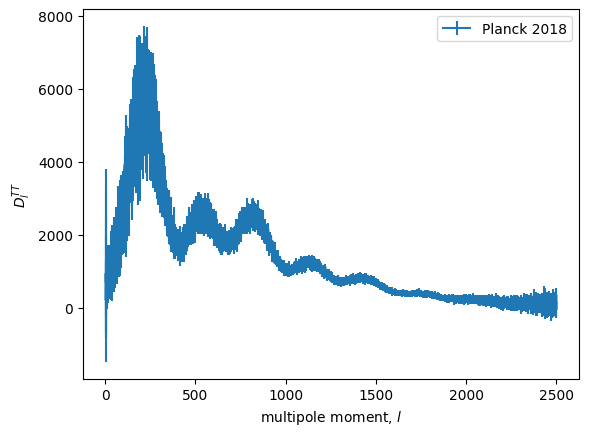

In [5]:
#Visualize the Planck 2018 data
#errorbar assumes symmetric errorbars - this is not the case for the Planck 2018 data, and the below plot is for visualization purposes only
plt.errorbar(data['l'], data['Dl'], 2*data['+dDl'], label='Planck 2018')
plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

Because we don't have an analytical model of the CMB temperature anisotropy (frankly, I've been unable to dtermine where one might exist), we're going to use the CLASS simulator to define our model for the MCMC. 

CLASS code and documentation can be found here: https://lesgourg.github.io/class_public/class.html#documentation
They request the following paper be cited when the software is use in publication: https://arxiv.org/abs/1104.2933

In [6]:
age = 0
def model(theta, age = age):
    # for the first iteration of this code, let's just use the unaltered LambdaCDM model
    omega_b, omega_cdm, h, A_s, n_s, tau_reio= theta
    #Initiate CLASS
    LambdaCDM = Class()
    # pass model parameters
    LambdaCDM.set({'omega_b':omega_b,'omega_cdm':omega_cdm,'h':h,'A_s':A_s,'n_s':n_s,'tau_reio':tau_reio})
    #Set CLASS generator settings
    LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})

    # run class - this creates our model
    LambdaCDM.compute()

    return LambdaCDM
    # get the CMB power spectrum

def get_cls(cmb_model):
    all_cls = cmb_model.lensed_cl(2500)['tt'] #ls start at 0, so this gives cls up to l = 2500
    cls = all_cls[2:] #Our data start at l = 2
    return cls

def get_Dls(theta):
    CMB_model = model(theta)
    cls = get_cls(CMB_model)
    simulated_ls = CMB_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
    l = simulated_ls[2:]
    Dls = l*(l+1)*cls/(2*np.pi)
    return Dls

def log_likelihood(cls, x, y, yerr_up, yerr_down):
    # get the model Cl for the given 'l' (passed as x). The index of each l is l-2
    
    # indeces = np.linspace(0, len(x)-1, len(x)).astype(int)
    # indeces = np.linspace(2, 2500, 2499).astype(int)
    indeces = np.linspace(0, 2498, 2499).astype(int)
    model_y = cls[indeces]
    # calculate the likelihood
    y_err = yerr_down + yerr_up
    chi2 = np.sum((y - model_y)**2 / (y_err**2))

    ln_like = -0.5*chi2
    return ln_like

def check_priors(theta):
    # Prior ranges are inspired by the 1-sigma ranges summarized in this paper:https://www.aanda.org/articles/aa/pdf/2019/03/aa34060-18.pdf
    # I've taken the largest reported 1-sigma range for each parameter used the precision on the last digit to determine the prior (this makes them slightly assymetric in terms of amount above/below the 1 sigma interval, but I'm okay with that).
    omega_b, omega_cdm, h, A_s, n_s, tau_reio = theta
    # LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
    # if (not (omega_b/h**2 + omega_cdm/h**2) < 1):
    #     #Make sure we don't overload the total energy density
    #     return False
    if not(0.0221 < omega_b <0.0225):
        return False
    if not(0.11 < omega_cdm <0.13):
        return False
    if not(0.65 < h <0.69):
        return False
    if not (0.04 < tau_reio < 0.09):
        return False
    if not(0.95 < n_s <0.97):
        return False
    if not(1.5e-9 < A_s <3.5e-9):   
        #Choosing a larger range here because the parameters used in the CLASS example vary more widely than those in the paper I used for the priors 
        return False
    if not(0.95 < n_s <0.98):
        #The paper does not address power spectrum tilt
        return False
    return True

# Based on the errors when running the MCMC below, it looks like we need to at least include consistency relations based on the actual cosmological relationships. This will be Monday's problem.

def ln_prob(theta, x, y, yerr_up, yerr_down):
    omega_b, omega_cdm, h, A_s, n_s, tau_reio= theta
    # Check if this set of parameters is allowed
    possible = check_priors(theta)
    if not possible:
        return -np.inf
    # Get the model
    CMB_model = model(theta)

    cls = get_cls(CMB_model)

    simulated_ls = CMB_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
    l = simulated_ls[2:]
    Dls = l*(l+1)*cls/(2*np.pi)

    # get the likelihood
    ln_likelihood = log_likelihood(Dls, x, y, yerr_up, yerr_down)
    return ln_likelihood
# from the "warmup" notebook:
# # create instance of the class "Class"
# LambdaCDM = Class()
# # pass input parameters
# LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
# LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# # run class
# LambdaCDM.compute()

In [260]:
n_iterations = 10
sampler, pos, prob, state = run_sampler(p0, n_walkers,n_iterations, n_dim, ln_prob)

Running burn-in...
Running production...


In [11]:
Dls = data['Dl']
ls = data['l']

def plotter(sampler,ls = ls, dls=Dls):
    plt.ion()
    plt.plot(ls, dls,label="$D_l^{TT}$")
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=10)]:
        Dls = get_Dls(theta)
        plt.plot(ls, Dls, color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('l')
    plt.ylabel("$D_l^{TT}$")
    plt.legend()
    plt.show()

CosmoComputationError: 

Error in Class: primordial_init(L:277) :error in primordial_analytic_spectrum_init(ppt, ppm);
=>primordial_analytic_spectrum_init(L:787) :condition (one_amplitude <= 0.) is true; inconsistent input for primordial amplitude: -3.58344e-08 for index_md=0, index_ic=0


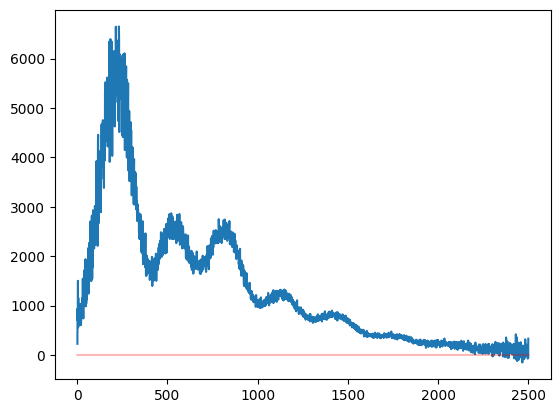

In [12]:
plotter(sampler)

In [258]:
ln_prob(theta_cdm, data['l'], data['Dl'], data['+dDl'], data['-dDl'])


-inf

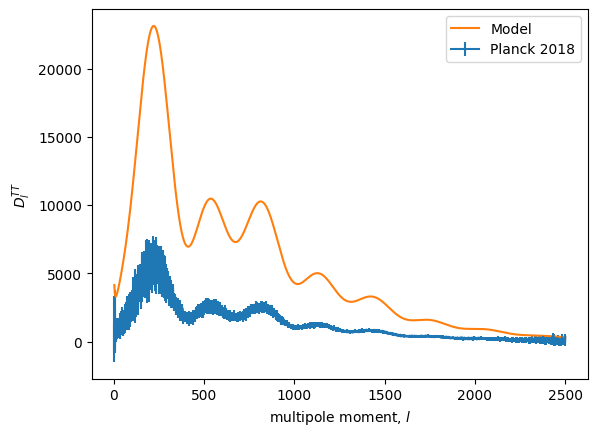

In [211]:
plt.errorbar(data['l'], data['Dl'], 2*data['+dDl'], label='Planck 2018')
theta_cdm = [0.0223828, 0.1201075, 0.67810, 2.100549e-09, 0.9660499, 0.05430842]
cmb_model = model(theta_cdm)
simulated_ls = cmb_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
ls = simulated_ls[2:]
dls = (get_cls(cmb_model))*ls*(ls + 1)/(2*np.pi)
plt.plot(ls, dls*10**13, label='Model')
plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

In [7]:
# Now, we set up the MCMC sampler
# This code, as well as the MCMC running function, is taken almost directly from the MCMC tutorial cited above

# Set up you 'guess' for the MCMC (IE, the first theta)
theta_start = np.array([0.0223828, 0.1201075, 0.67810, 2.100549e-09, 0.9660499, 0.05430842])
#theta_start = np.array([0.0283828, 0.8201075, 0.68810, 2.800549e-09, 0.9160499, 0.0540842])

# Set up the number of walkers and iterations for each walker
n_dim  = len(theta_start)
n_walkers = 100

# Each walker will start at a 1e-7 fluctuation from the guess
p0 = [np.array(theta_start) + 1e-7 * np.random.randn(n_dim) for i in range(n_walkers)]

In [8]:
def run_sampler(p0, nwalkers, niter, ndim, lnprob):

    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (data['l'], data['Dl'], data['+dDl'], data['-dDl']))
    # The burn-in sample allows us to start off with a better 'initial guess' for our overall analysis
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 100)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [9]:
n_iterations = 10
sampler, pos, prob, state = run_sampler(p0, n_walkers,n_iterations, n_dim, ln_prob)

Running burn-in...


/opt/homebrew/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


Running production...


You must install the tqdm library to use progress indicators with emcee


In [169]:
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes','P_k_max_1/Mpc':3.0})
# run class
LambdaCDM.compute()

In [170]:
# get all C_l output
cls = LambdaCDM.lensed_cl(2500)
# To check the format of cls
cls.keys()

dict_keys(['tt', 'ee', 'te', 'bb', 'pp', 'tp', 'ell'])

In [171]:
ll = cls['ell'][2:]
clTT = cls['tt'][2:]
clEE = cls['ee'][2:]
clPP = cls['pp'][2:]

In [172]:
# uncomment to get plots displayed in notebook
%matplotlib inline
import matplotlib.pyplot as plt
from math import pi

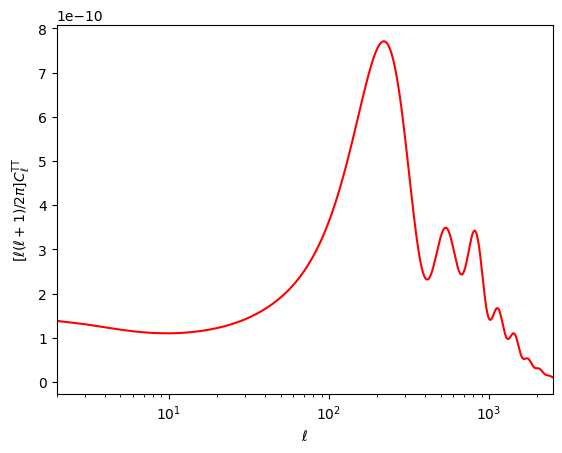

In [173]:
# plot C_l^TT
plt.figure(1)
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$[\ell(\ell+1)/2\pi]  C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT*ll*(ll+1)/2./pi,'r-')

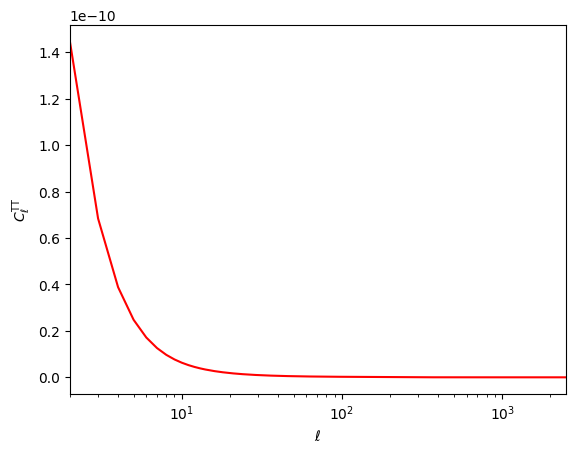

In [174]:
# plot C_l^TT
plt.figure(1)
plt.xscale('log');plt.yscale('linear');plt.xlim(2,2500)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$ C_\ell^\mathrm{TT}$')
plt.plot(ll,clTT,'r-')

In [31]:
# get P(k) at redhsift z=0
import numpy as np
kk = np.logspace(-4,np.log10(3),1000) # k in h/Mpc
Pk = [] # P(k) in (Mpc/h)**3
h = LambdaCDM.h() # get reduced Hubble for conversions to 1/Mpc
for k in kk:
    Pk.append(LambdaCDM.pk(k*h,0.)*h**3) # function .pk(k,z)

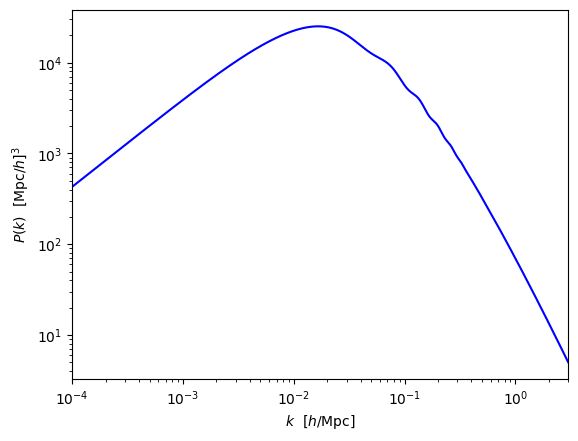

In [32]:
# plot P(k)
plt.figure(2)
plt.xscale('log');plt.yscale('log');plt.xlim(kk[0],kk[-1])
plt.xlabel(r'$k \,\,\,\, [h/\mathrm{Mpc}]$')
plt.ylabel(r'$P(k) \,\,\,\, [\mathrm{Mpc}/h]^3$')
plt.plot(kk,Pk,'b-')

In [33]:
# optional: reset parameters to default in case you want 
# to set different parameters and rerun LambdaCDM.compute()
LambdaCDM.empty()